# 쿠버네티스 실습 6 - PVC
# 1. PVC 란?

- Persistent Volume (**PV**), Persistent Volume Claim (**PVC**) 는 stateless 한 Pod 이 **영구적**으로(persistent) **데이터를 보존**하고 싶은 경우 사용하는 리소스입니다.
- 도커에 익숙하신 분이라면 `docker run` 의 `-v` 옵션인 도커 볼륨과 유사한 역할을 한다고 이해할 수 있습니다.
- **PV** 는 관리자가 생성한 실제 저장 공간의 정보를 담고 있고, **PVC** 는 사용자가 요청한 저장 공간의 스펙에 대한 정보를 담고 있는 리소스입니다.
    - PV 와 PVC 의 차이에 대해서는 헷갈리실 수 있지만, 저희는 지금 당장 이해하지 않아도 괜찮습니다.
    - Pod 내부에서 작성한 데이터는 기본적으로 **언제든지 사라질 수 있기에**, **보존**하고 싶은 데이터가 있다면 Pod 에 **PVC 를 mount 해서** 사용해야 한다는 것만 기억하시면 됩니다.
- PVC 를 사용하면 여러 pod 간의 data 공유도 쉽게 가능합니다.

---

# 2. PVC 생성

- minikube 를 생성하면, 기본적으로 minikube 와 함께 설치되는 storageclass 가 존재합니다.
    - `kubectl get storageclass`를 통해 이미 설치된 storageclass 를 확인할 수 있습니다.
    - storageclass 에 대한 자세한 설명은 생략하겠습니다.
        - PVC 를 생성하면 해당 PVC 의 스펙에 맞는 PV 를 그 즉시 자동으로 생성해준 뒤, PVC 와 매칭시켜준다고만 이해하시면 됩니다. (dynamic provisioning 지원하는 storageclass)

```
vi pvc.yaml

apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: myclaim
spec: # pvc 의 정보를 입력하는 파트입니다.
  accessModes:
    - ReadWriteMany # ReadWriteOnce, ReadWriteMany 옵션을 선택할 수 있습니다.
  volumeMode: Filesystem
  resources:
    requests:
      storage: 10Mi # storage 용량을 설정합니다.
  storageClassName: standard # 방금 전에 확인한 storageclass 의 name 을 입력합니다.
  

kubectl apply -f pvc.yaml

kubectl get pvc,pv
# pvc 와 동시에 pv 까지 방금 함께 생성된 것을 확인할 수 있습니다.

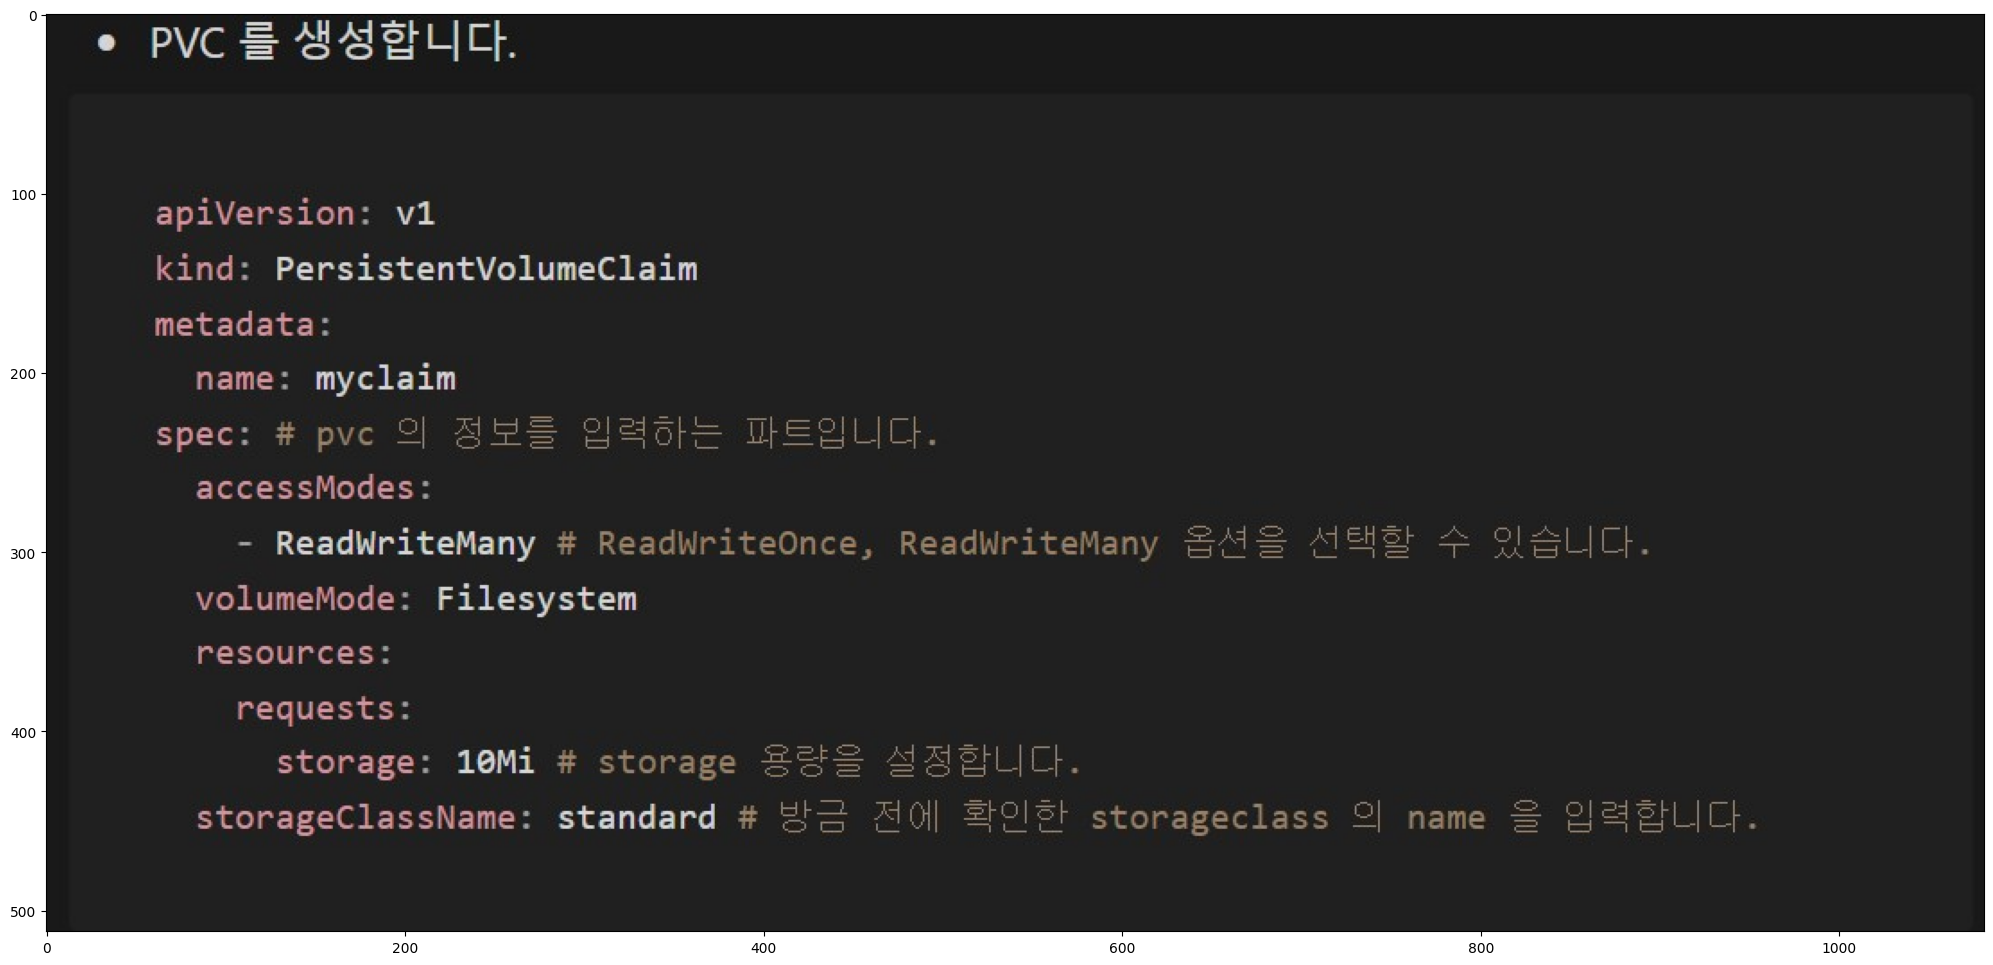

In [5]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

def display(start, end):
    for i in range(end+1):
        if i > start-1:
            GAP = cv2.imread(f'yaml{i}.jpg')
            GAP = cv2.cvtColor(GAP, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(25,25))
            plt.imshow(GAP)
            plt.show()

display(start=8, end=8)

In [6]:
!kubectl get storageclass

NAME                 PROVISIONER                RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
standard (default)   k8s.io/minikube-hostpath   Delete          Immediate           false                  11h


In [7]:
!kubectl apply -f pvc.yaml

persistentvolumeclaim/myclaim created


In [8]:
!kubectl get pvc,pv
# pvc 와 동시에 pv 까지 방금 함께 생성된 것을 확인할 수 있습니다.

NAME                            STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS   AGE
persistentvolumeclaim/myclaim   Bound    pvc-a6365f7c-546a-4eb8-ad61-c5db612b58d4   10Mi       RWX            standard       9s

NAME                                                        CAPACITY   ACCESS MODES   RECLAIM POLICY   STATUS   CLAIM             STORAGECLASS   REASON   AGE
persistentvolume/pvc-a6365f7c-546a-4eb8-ad61-c5db612b58d4   10Mi       RWX            Delete           Bound    default/myclaim   standard                9s


# 3. Pod 에서 PVC 사용

- Pod 을 생성합니다.
    - volumeMounts, volumes 부분이 추가되었습니다.

```
vi pod-pvc.yaml

apiVersion: v1
kind: Pod
metadata:
  name: mypod
spec:
  containers:
    - name: myfrontend
      image: nginx
      volumeMounts:
      - mountPath: "/var/www/html" # mount 할 pvc 를 mount 할 pod 의 경로를 적습니다.
        name: mypd # 어떤 이름이든 상관없으나, 아래 volumes[0].name 과 일치해야 합니다.
  volumes:
    - name: mypd # 어떤 이름이든 상관없으나, 위의 volumeMounts[0].name 과 일치해야 합니다.
      persistentVolumeClaim:
        claimName: myclaim # mount 할 pvc 의 name 을 적습니다.

kubectl apply -f pod-pvc.yaml

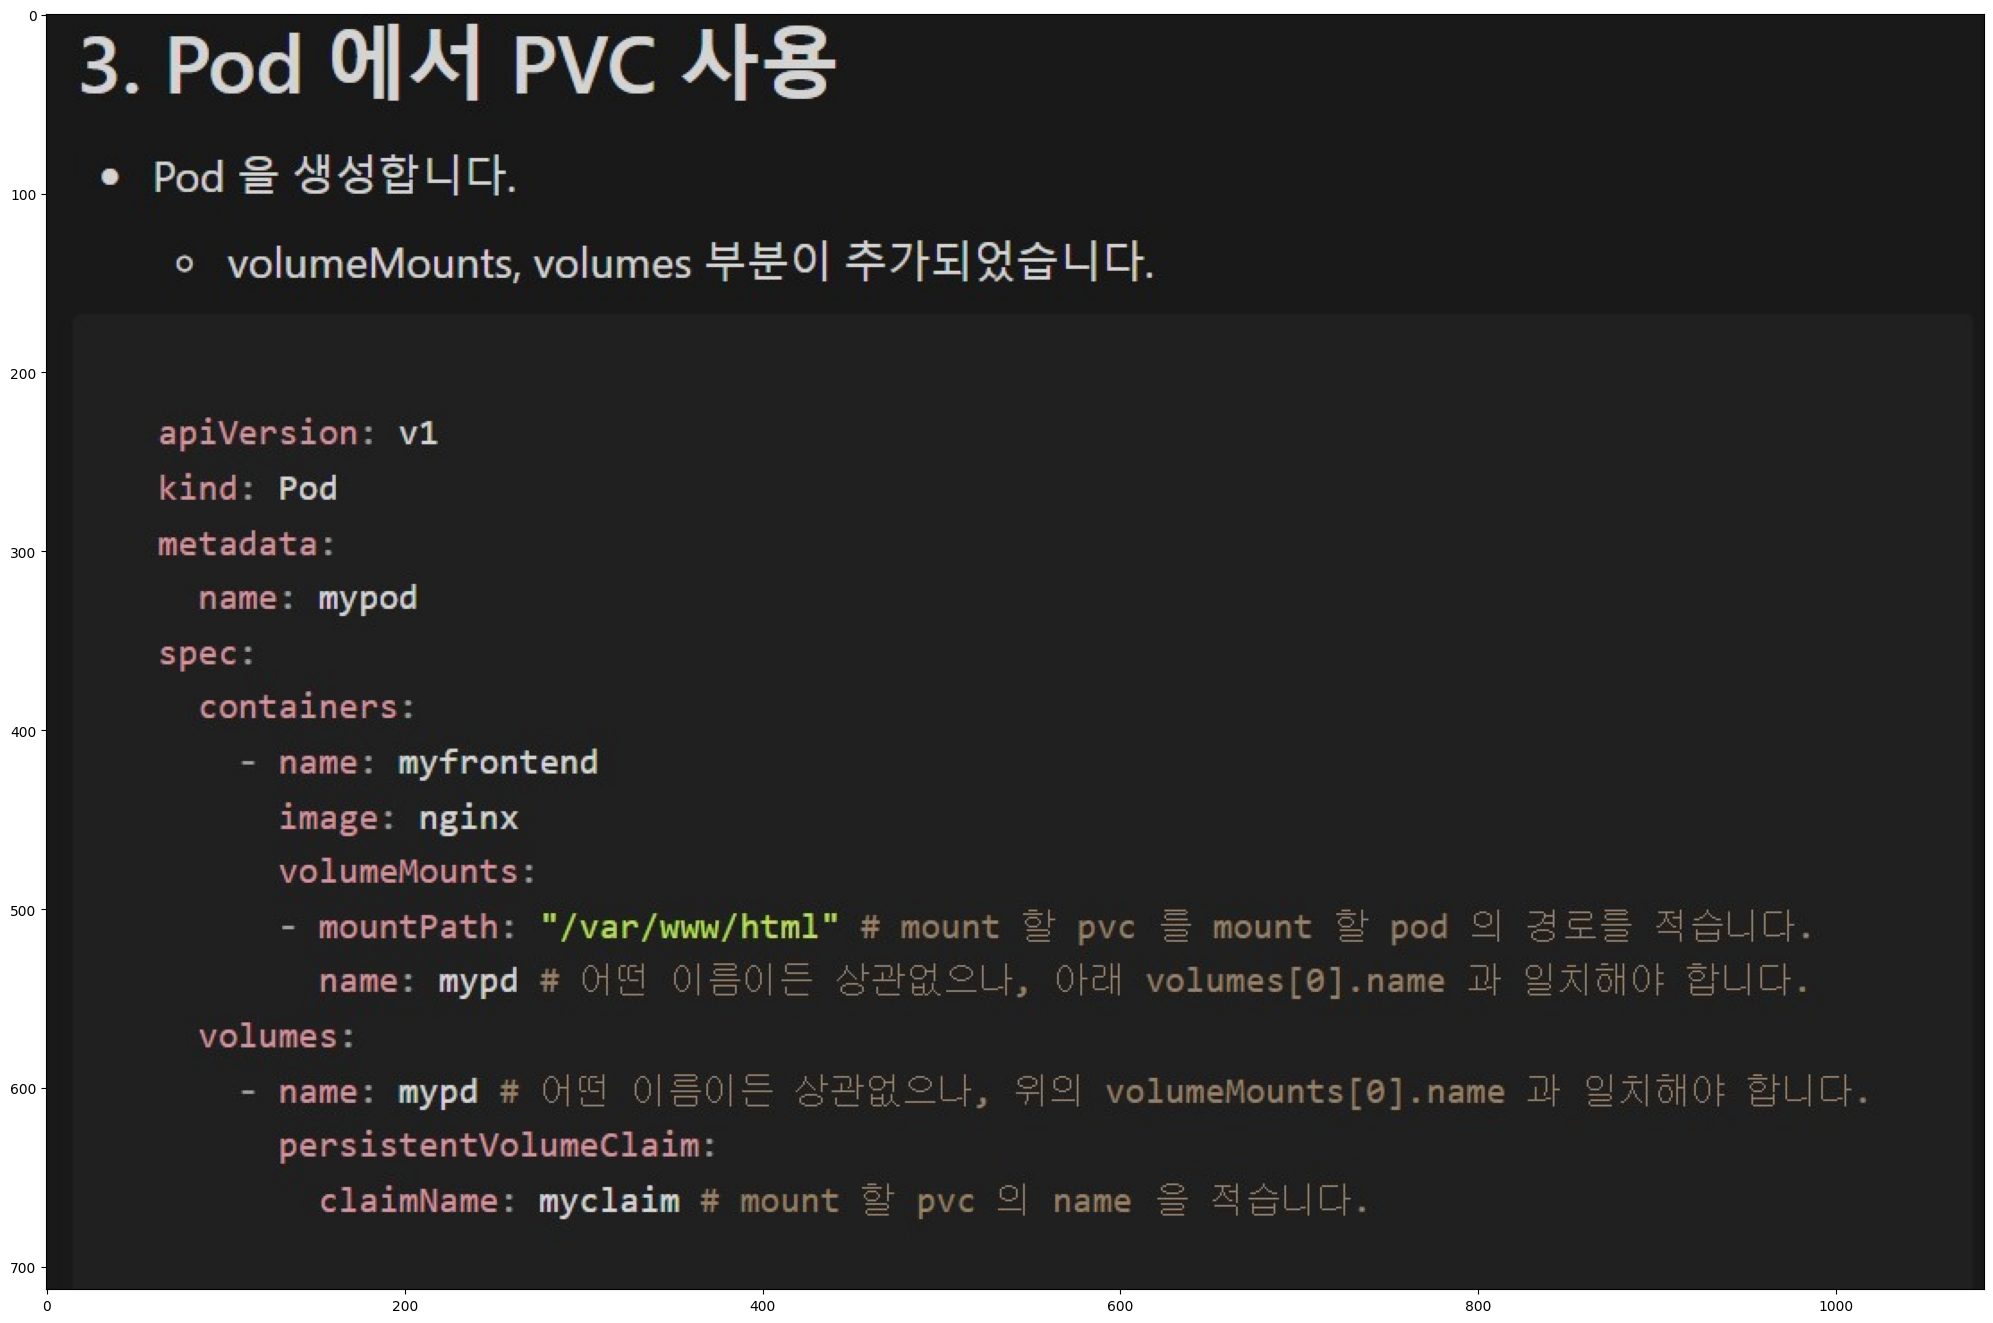

In [9]:
display(start=9, end=9)

In [10]:
!kubectl apply -f pod-pvc.yaml

pod/mypod created


In [14]:
!kubectl get pod

NAME                                READY   STATUS    RESTARTS   AGE
mypod                               1/1     Running   0          6m25s
nginx-deployment-66b6c48dd5-9nsx6   1/1     Running   0          63m
nginx-deployment-66b6c48dd5-h6xk4   1/1     Running   0          63m
nginx-deployment-66b6c48dd5-mtrwc   1/1     Running   0          63m


- pod 에 접속하여 mount 한 경로와 그 외의 경로에 파일을 생성합니다.
```
kubectl exec -it mypod -- bash

touch hi-fast-campus

cd /var/www/html

touch hi-fast-campus

In [ ]:
# !kubectl exec -it mypod -- bash

- pod 을 삭제합니다.

In [16]:
!kubectl delete pod mypod

pod "mypod" deleted


- pvc 는 그대로 남아있는지 확인합니다. : 그대로 살아있어야함

In [17]:
!kubectl get pvc,pv

NAME                            STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS   AGE
persistentvolumeclaim/myclaim   Bound    pvc-a6365f7c-546a-4eb8-ad61-c5db612b58d4   10Mi       RWX            standard       17m

NAME                                                        CAPACITY   ACCESS MODES   RECLAIM POLICY   STATUS   CLAIM             STORAGECLASS   REASON   AGE
persistentvolume/pvc-a6365f7c-546a-4eb8-ad61-c5db612b58d4   10Mi       RWX            Delete           Bound    default/myclaim   standard                17m


- 해당 pvc 를 mount 하는 pod 을 다시 생성합니다.

In [18]:
!kubectl apply -f pod-pvc.yaml

pod/mypod created


- pod 에 접속하여 아까 작성한 파일들이 그대로 있는지 확인합니다.
- pod내에서 hi-fast-campus는 보존되나 이외 mount 경로에서 만든 hi-fast-campus는 사라짐

```
kubectl exec -it mypod -- bash

ls
# hi-fast-campus 파일이 사라진 것을 확인할 수 있습니다.

cd /var/www/html

ls
# hi-fast-campus 파일이 그대로 보존되는 것을 확인할 수 있습니다.


- 쿠버네티스 관련 실습은 여기서 마무리하도록 하겠습니다. 그동안 정말 고생 많으셨습니다!

- 추가적으로 쿠버네티스에 대해 조금 더 알아보고 싶으신 분들은 kubernetes 공식 문서 혹은 해당 페이지에서 제공하는 interactive tutorial 을 따라해보시면 많은 도움이 될 것입니다.